In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 10 13:17:46 2022

@author: BetzLab-Admin
"""
from time import sleep
from pipython import GCSDevice
from pipython import pitools
from scipy.signal import fftconvolve
import keyboard
from math import cos, sin, pi
import numpy as np
from pycromanager import Core,Studio
from detection_methods import trajectory_corr, trajectory_gauss, trajectory_mean,trajectory_till, trajectory_till_stepwise,most_common_value, compare_trajectories, plt_accuracy_results, trajectory_polar_comparison,save_result, load_result
from detection_methods import make_test_trajectory as make_movie
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage import label
import csv
import random
import os
import pandas as pd

#from pipython.datarectools import getservotime

#core.set_exposure(0.5)##sets the cameras exposure time for snapshots to half a milisecond

In [2]:
pidevice= GCSDevice('E-727')
STAGES=None
REFMODES=None
core=Core()
pidevice.InterfaceSetupDlg()

pidevice.SVO('1', True)
pidevice.SVO('2', True)
pidevice.SVO('3', True)


In [3]:

def big_image_dispacement(image_1,image_2):
    mcv=most_common_value(np.array([image_1,image_2]).flatten())
    image_1=image_1-mcv
    image_2=image_2-mcv
    conv=fftconvolve(image_1,np.flip(image_2),mode='same')
    ind = np.unravel_index(np.argmax(conv, axis=None), conv.shape)
    x_shift=-ind[1]+np.shape(image_1)[0]/2
    y_shift=-ind[0]+np.shape(image_1)[1]/2
    return [x_shift, y_shift]
def mask_around_max(image, x_length=5, y_length=5):
    """
    Sets all values in the image to 0 which are outside the box specified by x_length and y_length around the pixel with the maximum value.

    Parameters:
    - image (np.array): The 2D array (image) to be processed.
    - x_length (int): The horizontal size of the box centered around the max value. Defaults to 5.
    - y_length (int): The vertical size of the box centered around the max value. Defaults to 5.

    Returns:
    - np.array: The processed image.
    """
    
    # Create a copy of the input image to avoid modifying the original
    processed_image = image.copy()
    
    # Locate the position of the maximum value
    max_y, max_x = np.unravel_index(np.argmax(processed_image), processed_image.shape)
    
    # Calculate box bounds
    x_left, x_right = max_x - x_length // 2, max_x + x_length // 2
    y_top, y_bottom = max_y - y_length // 2, max_y + y_length // 2
    
    # Create a box mask
    mask = ~((np.arange(processed_image.shape[1])[None, :] >= x_left) & 
             (np.arange(processed_image.shape[1])[None, :] <= x_right) & 
             (np.arange(processed_image.shape[0])[:, None] >= y_top) & 
             (np.arange(processed_image.shape[0])[:, None] <= y_bottom))
    
    # Set the values outside this box to zero
    processed_image[mask] = 0
    
    return processed_image


def center_of_mass(img):
    rows, cols = np.indices(img.shape)
    total_weight = img.sum()

    if total_weight == 0:
        return img.shape[0] / 2, img.shape[1] / 2  # Return the geometric center

    com_x = np.sum(cols * img) / total_weight
    com_y = np.sum(rows * img) / total_weight
    
    return com_y, com_x


In [15]:
dy=25
dx=25
move_stage(pidevice, 1, 50)
move_stage(pidevice, 2,50)
sleep(1)
image_0 = snap_image()
move_stage(pidevice, 1, 50+dx)
move_stage(pidevice, 2,50)
sleep(1)
image_dx = snap_image()
move_stage(pidevice, 1, 50)
move_stage(pidevice, 2,50+dy)
sleep(1)
image_dy = snap_image()

#image_0=mask_around_max(image_0-np.mean(image_0), distance=50)
#image_dx=mask_around_max(image_dx-np.mean(image_dx), distance=50)
#image_dy=mask_around_max(image_dy-np.mean(image_dy), distance=50)


In [6]:
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from time import sleep

def capture_and_save_images(pidevice, save_path, base_position=(50, 50), 
                            dx_range=(-25, 25), dy_range=(-25, 25), step=5):
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    records = []
    image_number = [0]  # Using list for mutability in nested functions

    def move_to_position(x, y):
        move_stage(pidevice, 1, x)
        move_stage(pidevice, 2, y)
        sleep(1)

    def capture_image(dx, dy):
        nonlocal image_number
        filename = f'{save_path}/img{image_number[0]}_dx{dx}_dy{dy}.png'
        image_number[0] += 1
        image = snap_image()
        plt.imsave(filename, image)
        return {'dx': dx, 'dy': dy, 'filename': filename, 'time': datetime.now()}

    # Return to base and capture base image
    move_to_position(*base_position)
    records.append(capture_image(0, 0))

    for dx in range(dx_range[0], dx_range[1] + 1, step):
        for dy in range(dy_range[0], dy_range[1] + 1, step):
            
            # Move, capture image, and return to base
            move_to_position(base_position[0] + dx, base_position[1] + dy)
            records.append(capture_image(dx, dy))
            
            move_to_position(*base_position)
            records.append(capture_image(0, 0))

    df = pd.DataFrame(records)
    df.to_csv(f'{save_path}/image_positions.csv', index=False)
    return df


In [7]:
# Use the function
save_path="small_stage_fixed_calibration_images"
df=capture_and_save_images(pidevice,save_path)

In [8]:
# Load the dataframe
df_loaded = pd.read_csv(f"{save_path}/image_positions.csv")

def compute_com(filename, dx_value):
    """
    Computes the center of mass of the given image filename.

    If dx_value is greater than or equal to 10, 
    the left half of the image is set to its median value.

    Parameters:
    - filename (str): Path to the image file.
    - dx_value (int): dx value associated with the image.

    Returns:
    - tuple: The center of mass.
    """
    
    # Load the image from the filename
    image = plt.imread(filename)
    
    # Sum the image along the third axis
    image = np.sum(image, axis=2)
    
    # If dx_value is greater than or equal to 10, set the left half of the image to its median value
    if dx_value >= 10:
        mid_x = image.shape[1] // 2
        median_val = np.median(image)
        image[:, :mid_x] = median_val
    
    # Subtract median and apply mask
    image = mask_around_max(image-np.median(image), x_length=200, y_length=150)
    
    # Compute the center of mass
    return center_of_mass(image)

# Apply the compute_com function to each filename in the dataframe
df_loaded['center_of_mass'] = df_loaded.apply(lambda row: compute_com(row['filename'], row['dx']), axis=1)

# Split the center of mass into two separate columns for x and y:
df_loaded['com_x'] = df_loaded['center_of_mass'].apply(lambda x: x[0])
df_loaded['com_y'] = df_loaded['center_of_mass'].apply(lambda x: x[1])
df_loaded = df_loaded.drop(columns=['center_of_mass'])


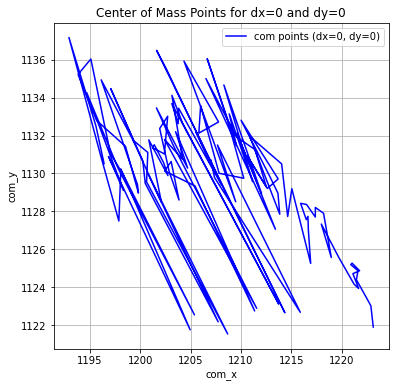

In [9]:
# Plotting
# Ensure that we only consider rows where dx and dy are 0
df_zero = df_loaded[(df_loaded['dx'] == 0) & (df_loaded['dy'] == 0)].copy()
plt.figure(figsize=(6, 6))
plt.plot(df_zero['com_x'], df_zero['com_y'], color='blue', label='com points (dx=0, dy=0)')
plt.title('Center of Mass Points for dx=0 and dy=0')
plt.xlabel('com_x')
plt.ylabel('com_y')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def create_displacement_df(df_loaded):
    zero_disp_df = df_loaded[(df_loaded['dx']==0) & (df_loaded['dy']==0)]
    unique_displacements = df_loaded.drop_duplicates(subset=['dx', 'dy'])

    # Placeholder for results
    results = []

    for _, row in unique_displacements.iterrows():
        dx_stage, dy_stage = row['dx'], row['dy']
        
        # If it's a zero displacement, continue
        if dx_stage == 0 and dy_stage == 0:
            continue

        # Find preceding and succeeding zero-displacement images
        preceding_zero = zero_disp_df[zero_disp_df['time'] < row['time']].iloc[-1]
        succeeding_zero = zero_disp_df[zero_disp_df['time'] > row['time']].iloc[0]

        dx_camera = row['com_x'] - preceding_zero['com_x']
        dy_camera = row['com_y'] - preceding_zero['com_y']

        sigma_camera = np.sqrt((succeeding_zero['com_x'] - preceding_zero['com_x'])**2 +
                               (succeeding_zero['com_y'] - preceding_zero['com_y'])**2)

        results.append([dx_stage, dy_stage, dx_camera, dy_camera, sigma_camera])

    # Convert results to DataFrame
    columns = ['dx_stage', 'dy_stage', 'dx_camera', 'dy_camera', 'sigma_camera']
    return pd.DataFrame(results, columns=columns)

new_df = create_displacement_df(df_loaded)


In [13]:
import statsmodels.api as sm

# Set the independent and dependent variables based on the entire dataframe
X = new_df[['dx_stage', 'dy_stage']]
y_dx = new_df['dx_camera']
y_dy = new_df['dy_camera']

from statsmodels.api import OLS

# Fit the models with intercept forced to be zero
model_dx = OLS(y_dx, X).fit()
model_dy = OLS(y_dy, X).fit()

# Predict values for all data points in new_df using the models
new_df['predicted_dx'] = model_dx.predict(X)
new_df['predicted_dy'] = model_dy.predict(X)

# Compute residuals for all data points in new_df
new_df['residual_dx'] = new_df['dx_camera'] - new_df['predicted_dx']
new_df['residual_dy'] = new_df['dy_camera'] - new_df['predicted_dy']

# Extracting coefficients and standard errors for dx_camera
coeff_dx = model_dx.params
stderr_dx = model_dx.bse

# Printing the fit parameters with uncertainties for dx_camera
print("For dx_camera:")
print(f"Coefficients: dx_stage: {coeff_dx['dx_stage']} ± {stderr_dx['dx_stage']}, dy_stage: {coeff_dx['dy_stage']} ± {stderr_dx['dy_stage']}")
print(f"R-squared: {model_dx.rsquared}")

# Extracting coefficients and standard errors for dy_camera
coeff_dy = model_dy.params
stderr_dy = model_dy.bse

# Printing the fit parameters with uncertainties for dy_camera
print("\nFor dy_camera:")
print(f"Coefficients: dx_stage: {coeff_dy['dx_stage']} ± {stderr_dy['dx_stage']}, dy_stage: {coeff_dy['dy_stage']} ± {stderr_dy['dy_stage']}")
print(f"R-squared: {model_dy.rsquared}")




For dx_camera:
Coefficients: dx_stage: 0.5162560707690977 ± 0.02444024603730439, dy_stage: 23.58970741628919 ± 0.024440246037304398
R-squared: 0.9998734141641572

For dy_camera:
Coefficients: dx_stage: 24.418607060141586 ± 0.04599791295978305, dy_stage: -0.01100927737989904 ± 0.04599791295978306
R-squared: 0.999581462289877


In [22]:
import numpy as np

# Parameter vectors
dx_params = np.array([coeff_dx['dx_stage'], coeff_dx['dy_stage']])  
dy_params = np.array([coeff_dy['dx_stage'], coeff_dy['dy_stage']])

# Uncertainty arrays 
dx_err = np.array([stderr_dx['dx_stage'], stderr_dx['dy_stage']])
dy_err = np.array([stderr_dy['dx_stage'], stderr_dy['dy_stage']]) 

# Vector magnitudes
dx_mag = np.linalg.norm(dx_params)
dy_mag = np.linalg.norm(dy_params)

# Uncertainties in magnitudes
dx_mag_err = dx_err.dot(dx_params) / dx_mag
dy_mag_err = dy_err.dot(dy_params) / dy_mag

# Angle between vectors
angle_rad = np.arccos(np.dot(dx_params, dy_params) / (dx_mag * dy_mag))
angle_deg = np.rad2deg(angle_rad) 

# Angle uncertainty
da = dx_err
db = dy_err

num = (1/np.sin(angle_rad)) * np.sqrt((np.dot(dy_params, da))**2 +  
                                       (np.dot(dx_params, db))**2)
den = dx_mag * dy_mag  
angle_err = np.rad2deg(num / den)

print(f"dx parameter vector magnitude: {dx_mag} +/- {dx_mag_err}")
print(f"dy parameter vector magnitude: {dy_mag} +/- {dy_mag_err}")
print(f"Angle between vectors (deg): {angle_deg} +/- {angle_err}")

dx parameter vector magnitude: 23.595355820939325 +/- 0.02496913727688497
dy parameter vector magnitude: 24.41860954194126 +/- 0.04597716984828826
Angle between vectors (deg): 88.77212549778088 +/- 0.1252378387397894


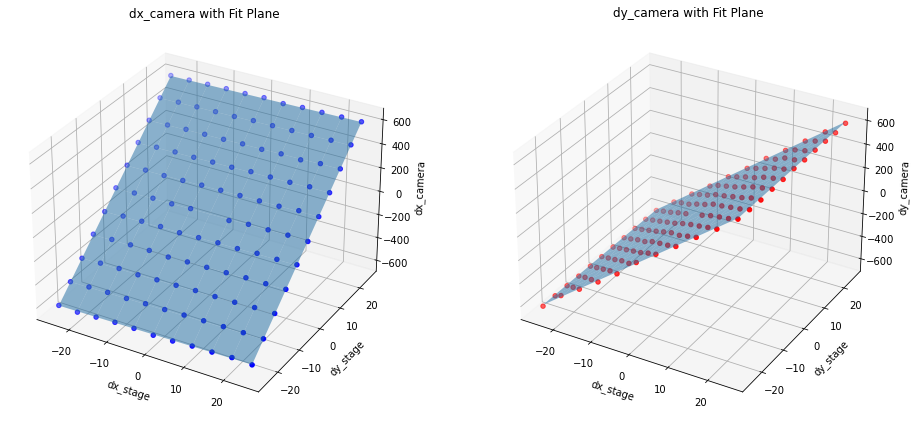

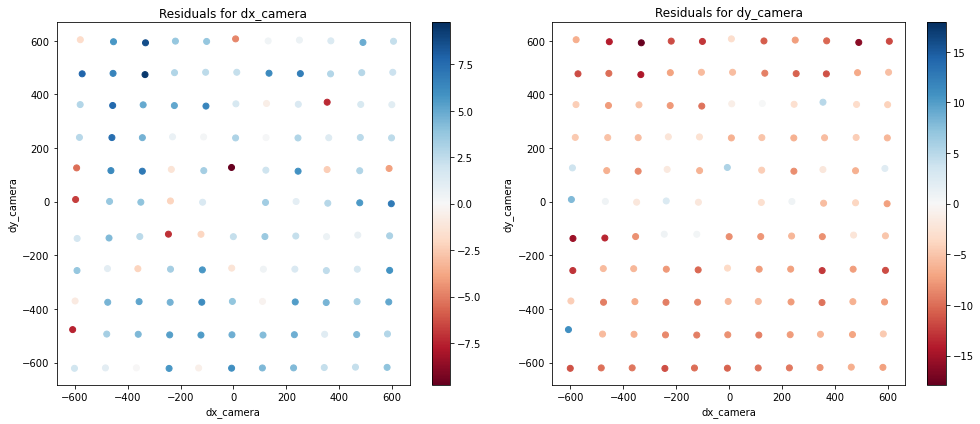

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 3D plots for dx_camera and dy_camera with fit planes
fig = plt.figure(figsize=(14, 6))

# Plot for dx_camera
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(new_df['dx_stage'], new_df['dy_stage'], new_df['dx_camera'], c='b', marker='o')
ax1.set_xlabel('dx_stage')
ax1.set_ylabel('dy_stage')
ax1.set_zlabel('dx_camera')
ax1.set_title('dx_camera with Fit Plane')

# Fit Plane for dx_camera
# Create a grid of values for dx_stage and dy_stage
xx, yy = np.meshgrid(new_df['dx_stage'].unique(), new_df['dy_stage'].unique())
# Create a dataframe from the grid to predict the z values for the plane
predict_df = pd.DataFrame({'dx_stage': xx.ravel(), 'dy_stage': yy.ravel()})
# Get the predicted z values for the plane
zz_dx = model_dx.predict(predict_df).values.reshape(xx.shape)
ax1.plot_surface(xx, yy, zz_dx, alpha=0.5)

# Plot for dy_camera
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(new_df['dx_stage'], new_df['dy_stage'], new_df['dy_camera'], c='r', marker='o')
ax2.set_xlabel('dx_stage')
ax2.set_ylabel('dy_stage')
ax2.set_zlabel('dy_camera')
ax2.set_title('dy_camera with Fit Plane')

# Get the predicted z values for the plane
zz_dy = model_dy.predict(predict_df).values.reshape(xx.shape)
ax2.plot_surface(xx, yy, zz_dy, alpha=0.5)

plt.tight_layout()
plt.show()

# 2D plots with residuals color-mapped
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Residuals for dx_camera
sc1 = ax1.scatter(new_df['dx_camera'], new_df['dy_camera'], c=new_df['residual_dx'], cmap='RdBu', vmin=-np.max(np.abs(new_df['residual_dx'])), vmax=np.max(np.abs(new_df['residual_dx'])))
ax1.set_xlabel('dx_camera')
ax1.set_ylabel('dy_camera')
ax1.set_title('Residuals for dx_camera')
plt.colorbar(sc1, ax=ax1)

# Residuals for dy_camera
sc2 = ax2.scatter(new_df['dx_camera'], new_df['dy_camera'], c=new_df['residual_dy'], cmap='RdBu', vmin=-np.max(np.abs(new_df['residual_dy'])), vmax=np.max(np.abs(new_df['residual_dy'])))
ax2.set_xlabel('dx_camera')
ax2.set_ylabel('dy_camera')
ax2.set_title('Residuals for dy_camera')
plt.colorbar(sc2, ax=ax2)

plt.tight_layout()
plt.show()


In [15]:
import json

# Create a dictionary to store the fit parameters and their standard errors
fit_parameters = {
    'dx_camera': {
        'coeff_dx_stage': coeff_dx['dx_stage'],
        'coeff_dy_stage': coeff_dx['dy_stage'],
        'stderr_dx_stage': stderr_dx['dx_stage'],
        'stderr_dy_stage': stderr_dx['dy_stage'],
        'rsquared': model_dx.rsquared
    },
    'dy_camera': {
        'coeff_dx_stage': coeff_dy['dx_stage'],
        'coeff_dy_stage': coeff_dy['dy_stage'],
        'stderr_dx_stage': stderr_dy['dx_stage'],
        'stderr_dy_stage': stderr_dy['dy_stage'],
        'rsquared': model_dy.rsquared
    }
}

# Save the dictionary to a JSON file
with open(save_path+'/fit_parameters.json', 'w') as file:
    json.dump(fit_parameters, file, indent=4)